based on:http://kuanbutts.com/2018/12/24/peartree-with-walk-network/

In [10]:
import peartree as pt

import geopandas as gpd
from shapely.geometry import Point

import osmnx as ox

In [49]:
feed = pt.get_representative_feed('../../GTFS/zips/TBS.zip')

In [70]:
start = 7 * 60 * 60
end = 21 * 60 * 60 
%time G = pt.load_feed_as_graph(feed, start, end)

CPU times: user 5.9 s, sys: 64.2 ms, total: 5.96 s
Wall time: 6.13 s


/Users/eudald/opt/miniconda3/envs/iper/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


(<Figure size 864x864 with 1 Axes>, <AxesSubplot:>)

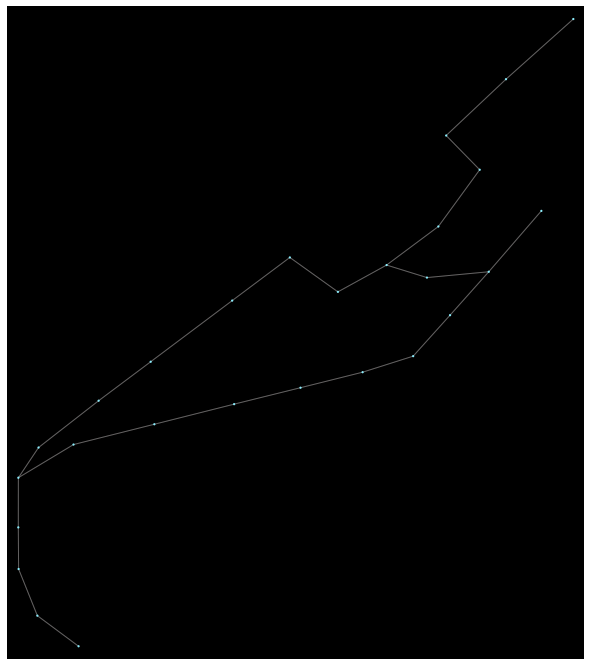

In [71]:
pt.plot.generate_plot(G)

In [81]:
# We need a coverage area, based on the points from the GTFS data, which we can pull from the peartree
# network graph by utilizing coordinate values and extracting a convex hull from the point cloud
boundary = gpd.GeoSeries([Point(n['x'], n['y']) for i, n in G.nodes(data=True)]).unary_union.convex_hull

In [82]:
# Pull in the walk network with OSMnx
%time Gwalk = ox.graph_from_polygon(boundary, network_type='walk')

CPU times: user 8.8 s, sys: 1.16 s, total: 9.95 s
Wall time: 15.1 s


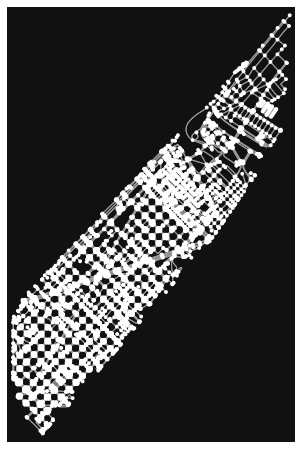

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [83]:
# Visually inspect (takes a minute or two)
ox.plot_graph(Gwalk)

In [84]:
# Note the edge structure of the peartree graph
list(G.edges(data=True))[0]

('75X7N_10', '75X7N_29', {'length': 60.0, 'mode': 'transit'})

In [85]:
# ...and that of the OSMnx graph
list(Gwalk.edges(data=True))[0]

(30242972,
 7650348412,
 {'osmid': 547289588,
  'oneway': False,
  'lanes': '3',
  'name': 'Carrer de Pujades',
  'highway': 'tertiary',
  'maxspeed': '50',
  'width': '9',
  'length': 21.295})

In [86]:
walk_speed = 4 

# Make a copy of the graph in case we make a mistake
Gwalk_adj = Gwalk.copy()

# Iterate through and convert lengths to seconds
for from_node, to_node, edge in Gwalk_adj.edges(data=True):
    orig_len = edge['length']
    
    # Note that this is a MultiDiGraph so there could be multiple indices here, I naively assume this is not the case
    Gwalk_adj[from_node][to_node][0]['orig_length'] = orig_len

    # Conversion of walk speed and into seconds from meters
    kmph = (orig_len / 1000) / walk_speed
    in_seconds = kmph * 60 * 60
    Gwalk_adj[from_node][to_node][0]['length'] = in_seconds
    
    # And state the mode, too
    Gwalk_adj[from_node][to_node][0]['mode'] = 'walk'

In [87]:
# Ensure that we now have both length values (and
# thus an updated edge schema)
list(Gwalk_adj.edges(data=True))[0]

(30242972,
 7650348412,
 {'osmid': 547289588,
  'oneway': False,
  'lanes': '3',
  'name': 'Carrer de Pujades',
  'highway': 'tertiary',
  'maxspeed': '50',
  'width': '9',
  'length': 19.1655,
  'orig_length': 21.295,
  'mode': 'walk'})

In [88]:
# So this should be easy - just go through all nodes and make them have a 0 cost to board
for i, node in Gwalk_adj.nodes(data=True):
    Gwalk_adj.nodes[i]['boarding_cost'] = 0

In [133]:
# Now that we have a formatted walk network it should be easy to reload the peartree graph and stack it on the walk network
start = 7 * 60 * 60
end = 9 * 60 * 60

# Note this will be a little slow - an optimization here would be to have coalesced the walk network
%time G2 = pt.load_feed_as_graph(feed, start, end, existing_graph=Gwalk_adj)

CPU times: user 1.23 s, sys: 21.1 ms, total: 1.25 s
Wall time: 1.27 s


In [136]:
# This is an issue that needs cleaning up
# slash I need to look into it more
# but some nodes that should have been
# cleaned out remain
print('All nodes', len(G2.nodes()))
bad_ns = [i for i, n in G2.nodes(data=True) if 'x' not in n]
print('Bad nodes count', len(bad_ns))

for bad_n in bad_ns:
    # Make sure they do not conenct to anything
    if len(G2[bad_n]) > 0:
        # This should not happen
        print(bad_n)

    else:
        # So just drop them
        G2.remove_node(bad_n)

All nodes 5341
Bad nodes count 97


(<Figure size 864x864 with 1 Axes>, <AxesSubplot:>)

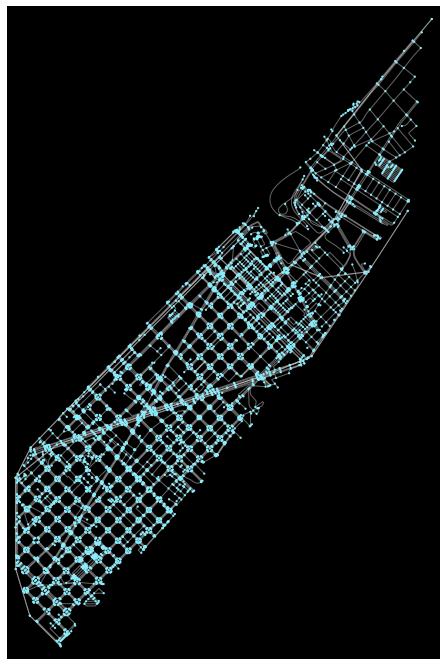

In [137]:
pt.plot.generate_plot(G2)

In [102]:
list(G2.edges(data=True))[0]

(30242972,
 7650348412,
 {'osmid': 547289588,
  'oneway': False,
  'lanes': '3',
  'name': 'Carrer de Pujades',
  'highway': 'tertiary',
  'maxspeed': '50',
  'width': '9',
  'length': 19.1655,
  'orig_length': 21.295,
  'mode': 'walk'})

KeyError: '4385659707'

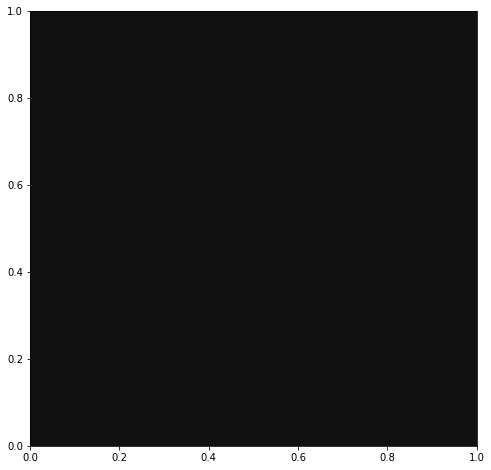

In [135]:
fig, ax = ox.plot_graph(G2, show=False, close=False, node_size = 0)


# then plot colored route segments on top of it
for n in G2.edges(data=True):
    data = n[2]
    print(data)
    
    if "geometry" in data:
        x, y = data["geometry"].xy
    else:
        x = G2.nodes[n[0]]["x"], G2.nodes[n[1]]["x"]
        y = G2.nodes[n[0]]["y"], G2.nodes[n[1]]["y"]       
        
    if data['mode'] == 'wlak':
        print('yes')
        ax.plot(x, y, color='r', lw=5)